In this notebook, we will go from the learning numpy and matplotlib to our first neural simulator.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
fig_width = 15
phi = (np.sqrt(5)+1)/2
phi = phi**2

# Mainen & Sejnowski, 1995

## contexte
Le but de cette première tache est de créer un "raster plot" qui montre la reproducibilité d'un train de spike avec des répétitions du même stimulus, comme dans ce travail dans la [rétine de rongeurs](https://laurentperrinet.github.io/2019-04-03_a_course_on_vision_and_modelization/#/1/3) ou dans le [cortex (V1) du chat](https://laurentperrinet.github.io/2019-04-03_a_course_on_vision_and_modelization/#/1/6).

Ici, nous allons essayer de répliquer la figure 1 de [Mainen & Sejnowski (1995)](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.299.8560&rep=rep1&type=pdf):

![Mainen Sejnowski 1995](http://i.stack.imgur.com/ixnrz.png "figure 1")

Et pour celà, nous allons procéder à plusieures étapes progressives à rédiger dans le [noteboook](src/A_0_IntegrateAndFire.ipynb):

## prise en main des outils: numpy et matplotlib

- on va créer des vecteurs représentant la dynamique d'un valeur en fonction du temps
- pour cela, on crée un vecteur `time' représentant 2 secondes avec une précision de dt=1ms
- dans un premier temps, on va créer un plot d'un spike, d'un créneau & d'une sinusoïde

## définition du problème: leaky-integrate and fire neuron

- on va simuler 1 neurone pour 2 secondes avec une précision de dt=1ms
- pour cela, on utilise l'équation d'un lIF
- on montre alors sa réponse aux stimuli créés ci-dessus

## injection d'un bruit

- Comme dans la figure 1 de Mainen & Sejnowski (1995), on ajoute un bruit à l'injection de courant
- ce bruit peut être caractisé par son amplitude et son temps caractéristique: quel est l'impact sur le résultat?
- que se passe-t-il quand on inclut un bruit interne à la dynamique du neurone?

## bonus: utilisation de pyNN / brian

- on va utiliser [brian](http://briansimulator.org/) pour écrire l'équation du lIF et refaire les mêmes simulations
- on compare avec d'autres modèles de neurone

## références

* http://e.guigon.free.fr/rsc/article/BretteGuigon03.pdf

# dynamic

In [2]:
time = np.arange(0, 1000, .5)

creating a step function, sequential version:

In [3]:
start = 50
end = 950

def Inp(time=time, start=start, end=end):
    x=[]
    for t in range(len(time)):
        if start < time[t] < end :
            x.append(200.)
        else:
            x.append(0)
    return x

I = Inp(time)


In [4]:
%%timeit
I = Inp(time)

2.11 ms ± 524 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


vectorized version:

In [5]:
def Inp(time=time, start=start, end=end):
    I = np.zeros_like(time)
    I[time>start] = 150.
    I[time>end] = 0
    return I
  
I = Inp(time)


In [6]:
%%timeit
I = Inp(time)

19.5 µs ± 4.75 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


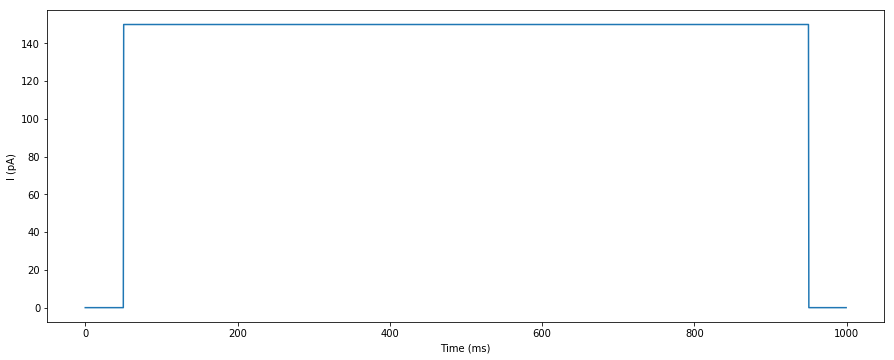

In [7]:
fig, ax = plt.subplots(figsize=(fig_width, fig_width/phi))
ax.plot(time, I)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('I (pA)');

## A simple leaky_IF model

Let's start by defining a simple neuron model:

$$
\tau \cdot \frac{dV}{dt} = -(V - V_{rest}) + R*I(t)
$$

with if $V > V_{rest}$, emit a spike and $V= V_{rest}$ for $3 ms$.


In [8]:
Vthreshold =-53
def leaky_IF(time=time, inp=I, tau=30, v0=-65, R=0.12, 
                Vthreshold =Vthreshold, Vreset = -80, Vspike=30, 
                VRest=-70):
    V = np.ones_like(time)*v0
    dt = time[1]
    for t in range(len(time)-1):
        n=np.random.randn()
        dV = dt * (-(V[t] - VRest) + R*inp[t])/tau
        V[t+1] = V[t] + dV
        
        if V[t]>Vthreshold:
            V[t+1]= Vspike
        if V[t] == Vspike:
            V[t+1]=Vreset
         
    return V

V = leaky_IF(time, I)


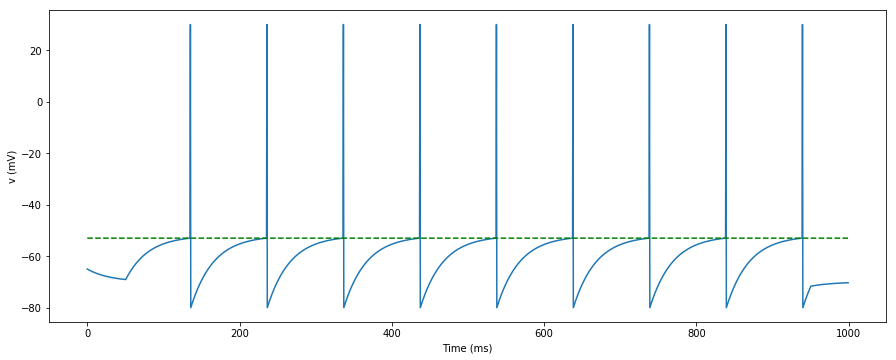

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.plot(time, V)
ax.plot(time, np.ones_like(time)*Vthreshold, 'g--')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('v (mV)');

Plusieurs essais montrent que c'est parfaitement reproductible, contrairement à la figure:

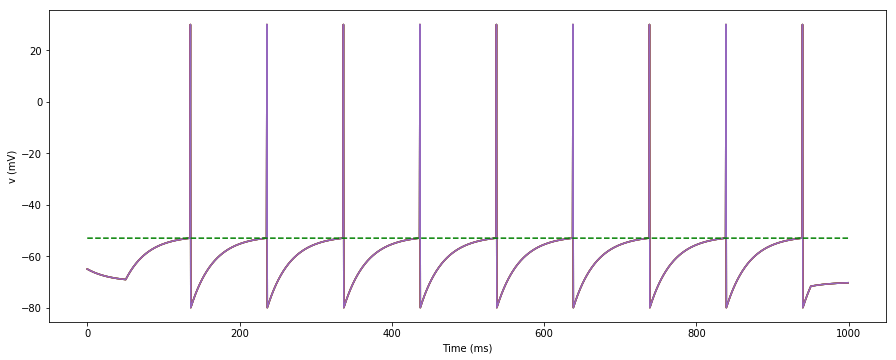

In [10]:
n_trials = 5
V1 = np.zeros((n_trials,len(time)))

for i in range(n_trials):
    V1[i, :] = leaky_IF()

fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.plot(time, V1.T)
ax.plot(time, np.ones_like(time)*Vthreshold, 'g--')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('v (mV)');

## Création d'un input bruité

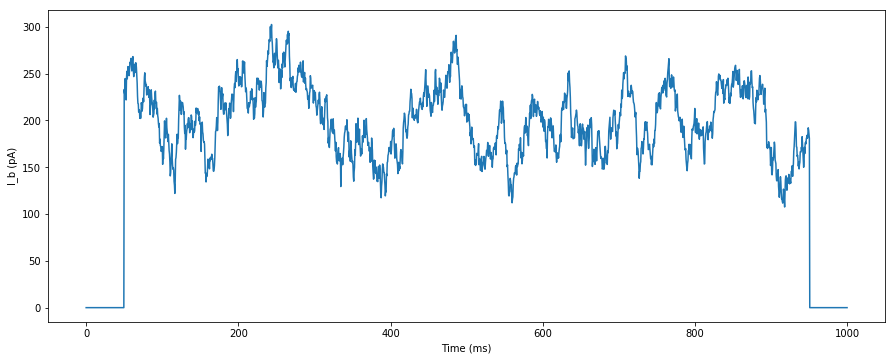

In [11]:
def Bruit(time=time, tau_n=30, I_n=500, I_0=200, start=start, end=end):
    dt = time[1]
    x=np.ones_like(time)
    for t in range(len(x)-1):
        n = np.random.randn()*I_n
        x[t+1]=(1-dt/tau_n)*x[t]+ (dt*n/tau_n)
    
    x += I_0
    x[time<start], x[time>end] = 0, 0
    
    return x

fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.plot(time, Bruit())
ax.set_xlabel('Time (ms)')
ax.set_ylabel('I_b (pA)');

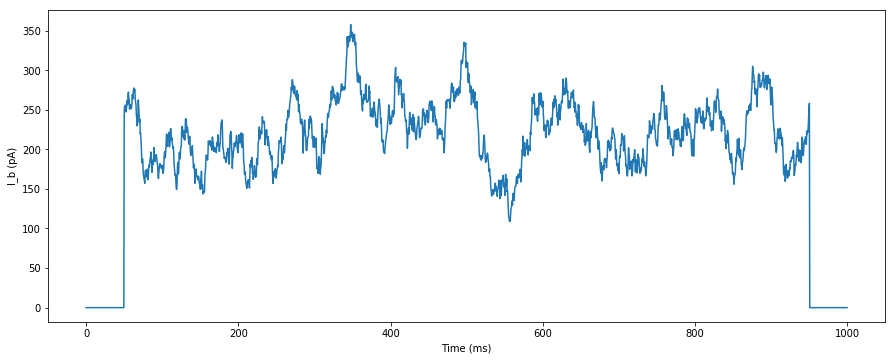

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.plot(time, Bruit())
ax.set_xlabel('Time (ms)')
ax.set_ylabel('I_b (pA)');

## Neurone LIF avec Input bruité

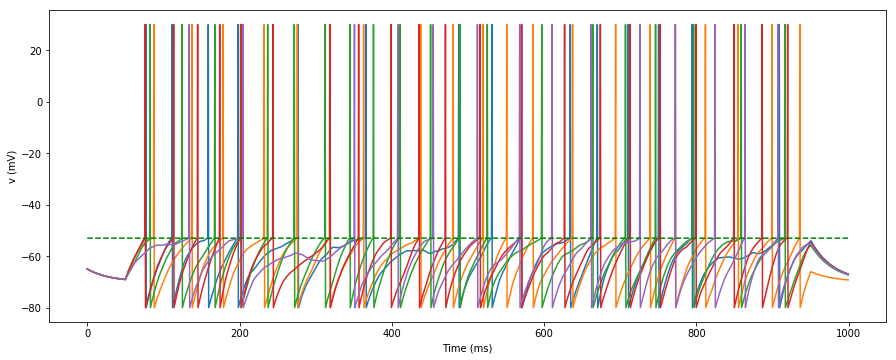

In [13]:
n_trials = 5
V1 = np.zeros((n_trials,len(time)))

for i in range(n_trials):
    V1[i, :] = leaky_IF(time, Bruit())

fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.plot(time, V1.T)
ax.plot(time, np.ones_like(time)*Vthreshold, 'g--')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('v (mV)');

I_0= 75.0


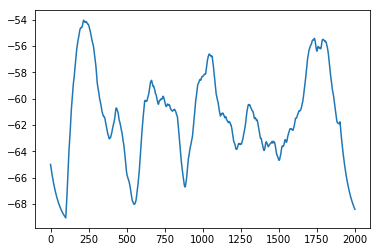

I_0= 101.25


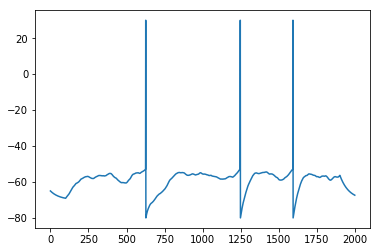

I_0= 127.5


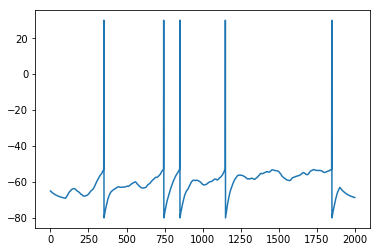

I_0= 153.75


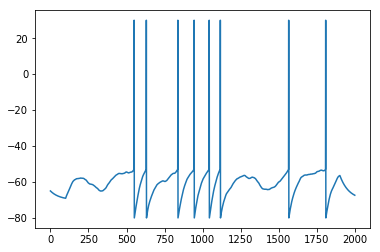

I_0= 180.0


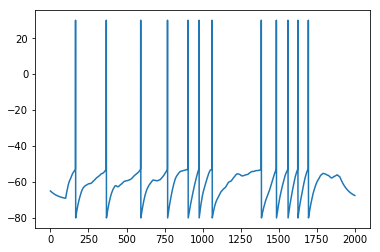

In [14]:
for rho in np.linspace(0.5, 1.2, 5):
    print('I_0=', rho*150)
    V= leaky_IF(time, Bruit(time, I_n=500, I_0=rho*150))

    plt.plot(V)
    plt.show()

I_n= 300.0


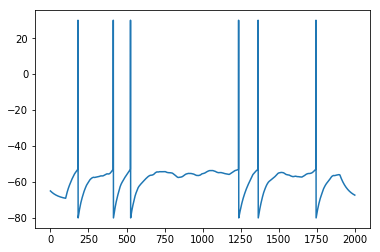

I_n= 399.99999999999994


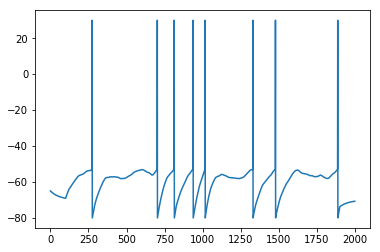

I_n= 500.0


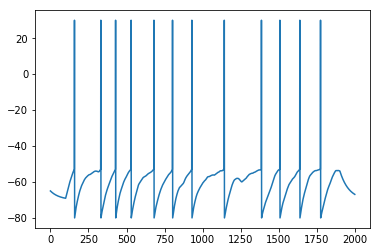

I_n= 600.0


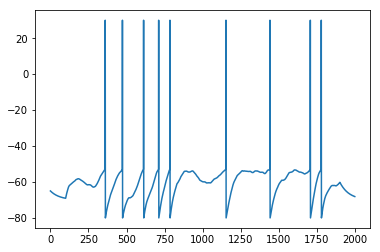

I_n= 700.0


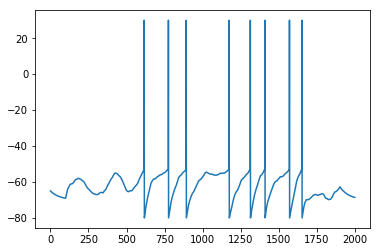

In [15]:
for rho in np.linspace(0.6, 1.4, 5):
    print('I_n=', rho*500)
    V= leaky_IF(time, Bruit(time, I_n=rho*500, I_0=150))

    plt.plot(V)
    plt.show()

## bruit gelé

In [16]:
help(np.random.seed)

Help on built-in function seed:

seed(...) method of mtrand.RandomState instance
    seed(seed=None)
    
    Seed the generator.
    
    This method is called when `RandomState` is initialized. It can be
    called again to re-seed the generator. For details, see `RandomState`.
    
    Parameters
    ----------
    seed : int or 1-d array_like, optional
        Seed for `RandomState`.
        Must be convertible to 32 bit unsigned integers.
    
    See Also
    --------
    RandomState



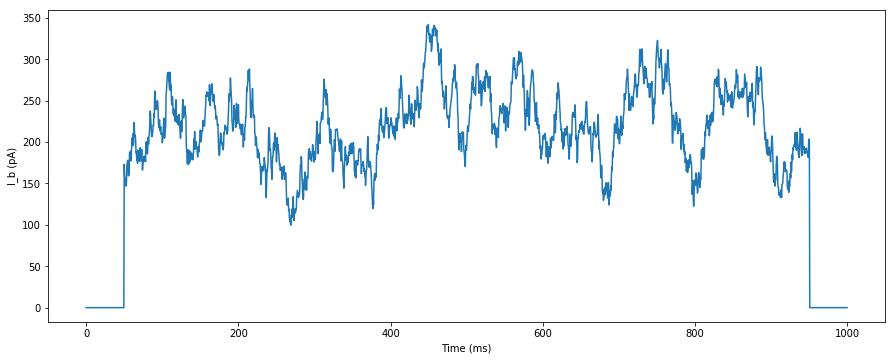

In [17]:
def Bruit(time=time, tau_n=20, I_n=400, I_0=200, seed=42, start=start, end=end):
    np.random.seed(seed)
    dt = time[1]
    x=np.ones_like(time)
    for t in range(len(x)-1):
        n = np.random.randn()*I_n
        x[t+1] = (1-dt/tau_n)*x[t]+ (dt*n/tau_n)
    
    x += I_0
    x[time<start], x[time>end] = 0,0
    
    return x

fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.plot(time, Bruit())
ax.set_xlabel('Time (ms)')
ax.set_ylabel('I_b (pA)');

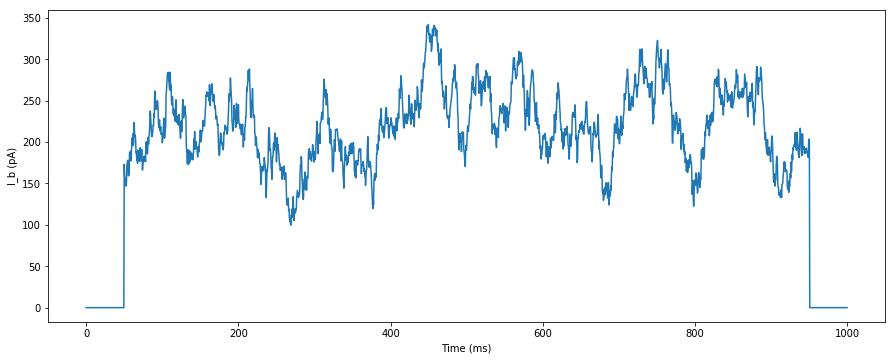

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.plot(time, Bruit())
ax.set_xlabel('Time (ms)')
ax.set_ylabel('I_b (pA)');

## Plusieurs trials
Maintien de la phase malgré un input bruité (bruit gelé)

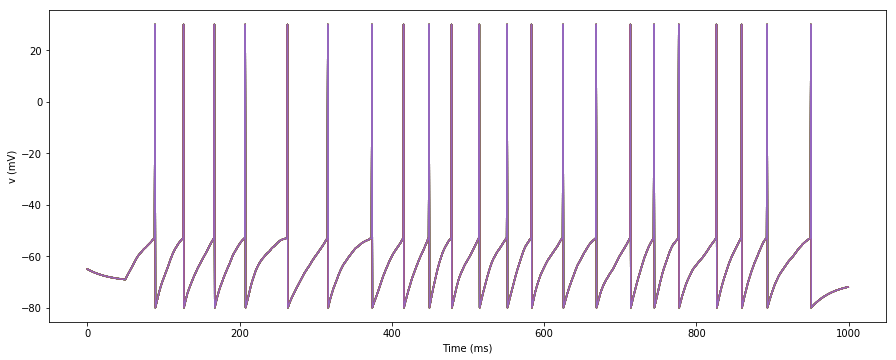

In [19]:
n_trials = 25
V1 = np.zeros((n_trials,len(time)))

for i in range(n_trials):
    V1[i, :] = leaky_IF(time, Bruit())

fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.plot(time, V1.T)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('v (mV)');


On reproduit le paneau B: avec un bruit gelé, les traces des neurones sont reproductibles.

Celà prouve aussi que l'on a "oublié" d'inclure un bruit intrinsèque à la dynamique du neurone:

In [20]:
def leaky_IF(time=time, inp=I, tau=30, v0=-65, R=0.12, 
                Vthreshold =-53, Vreset = -80, Vspike=30, 
                VRest=-70, b=100, seed=None):
    np.random.seed(seed)
    V = np.ones_like(time)*v0
    dt = time[1]
    for t in range(len(time)-1):
        n=np.random.randn()
        dV = dt * (-(V[t] - VRest) + R*(inp[t]+b*n))/tau
        V[t+1] = V[t] + dV
        
        if V[t]>Vthreshold:
            V[t+1]= Vspike
        if V[t] == Vspike:
            V[t+1]=Vreset
         
    return V


Plusieurs essais montrent qu'avec un créneau les temps des spikes perdent leur reproducibilité, comme sur la figure:

rho= 0.7


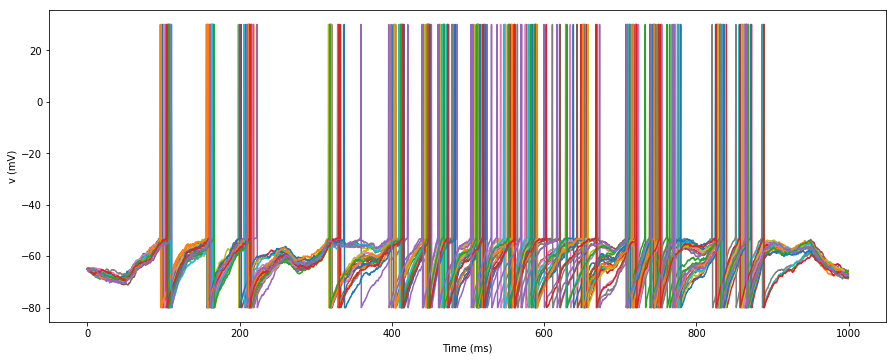

rho= 0.85


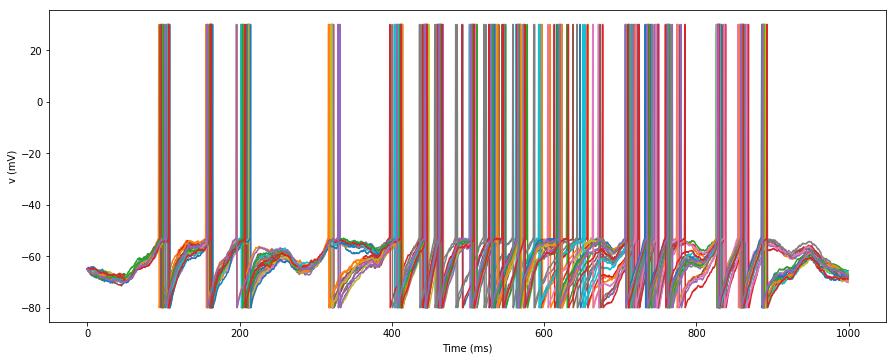

rho= 1.0


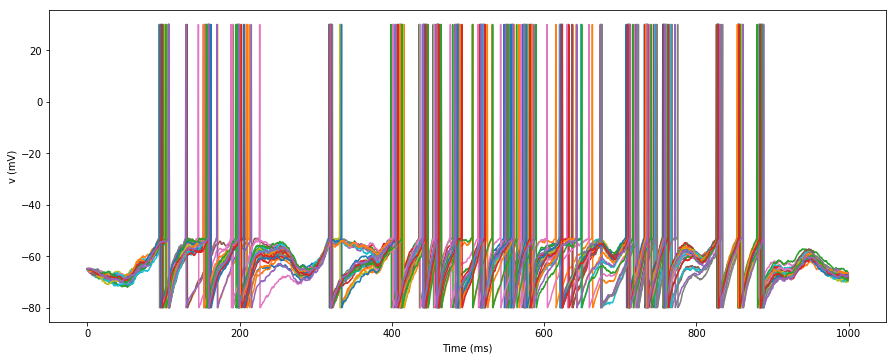

rho= 1.15


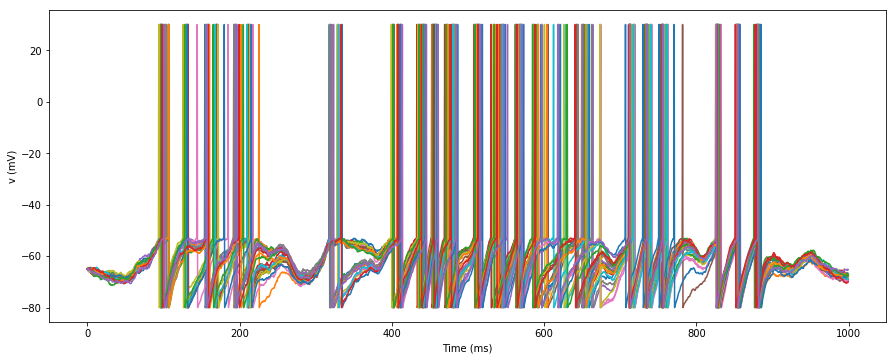

rho= 1.3


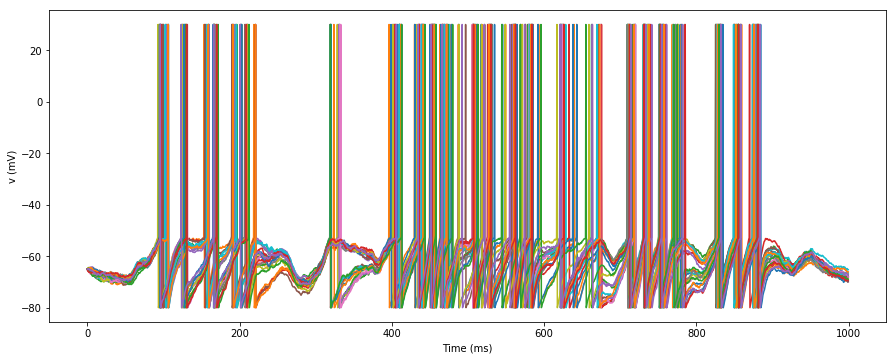

In [21]:
for rho in np.linspace(0.7, 1.3, 5):
    print('rho=', rho)
    VA = np.zeros((n_trials,len(time)))

    for i in range(n_trials):
        VA[i, :] = leaky_IF(time, Bruit(I_n=rho*1000, I_0=150))

    fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
    ax.plot(time, VA.T)
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('v (mV)');
    plt.show()

rho= 0.7


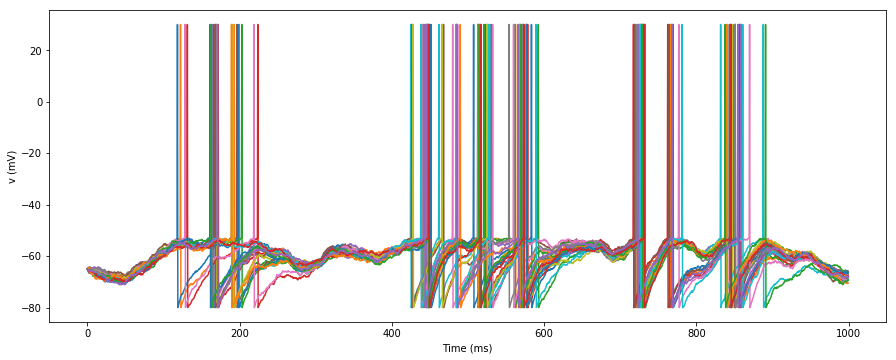

rho= 0.85


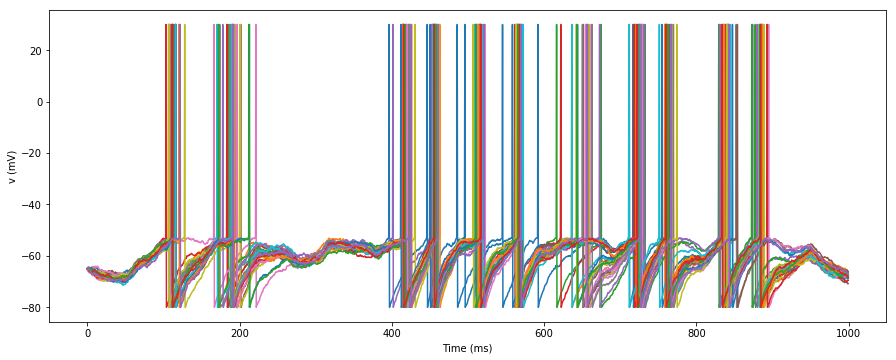

rho= 1.0


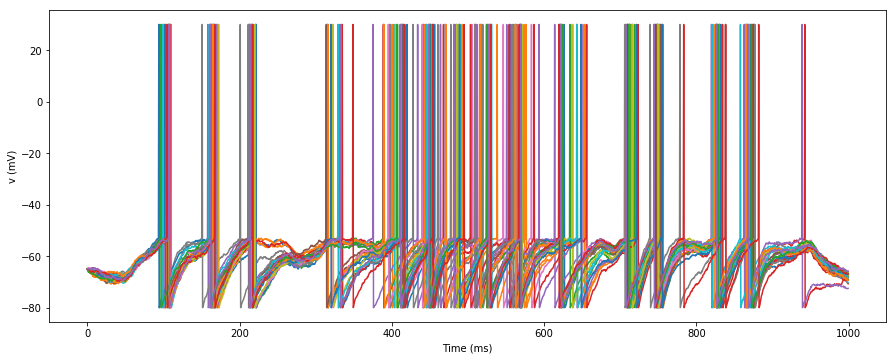

rho= 1.15


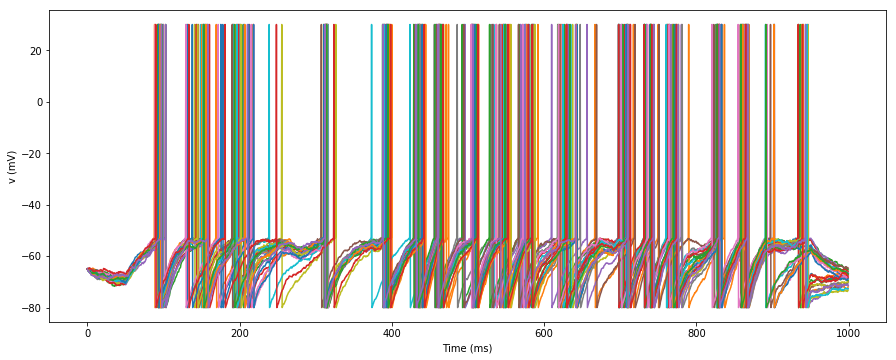

rho= 1.3


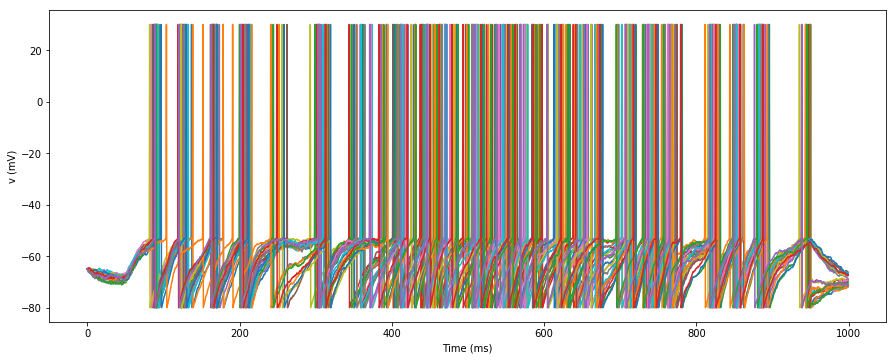

In [22]:
for rho in np.linspace(0.7, 1.3, 5):
    print('rho=', rho)
    VA = np.zeros((n_trials,len(time)))

    for i in range(n_trials):
        VA[i, :] = leaky_IF(time, Bruit(I_n=500, I_0=rho*150))

    fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
    ax.plot(time, VA.T)
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('v (mV)');
    plt.show()

rho= 0.9


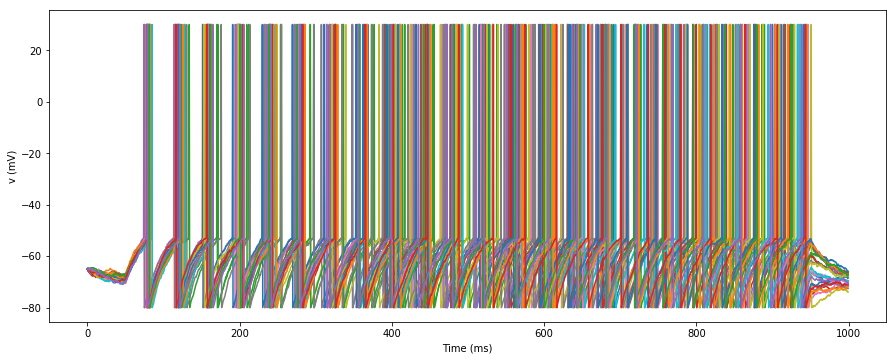

rho= 0.9500000000000001


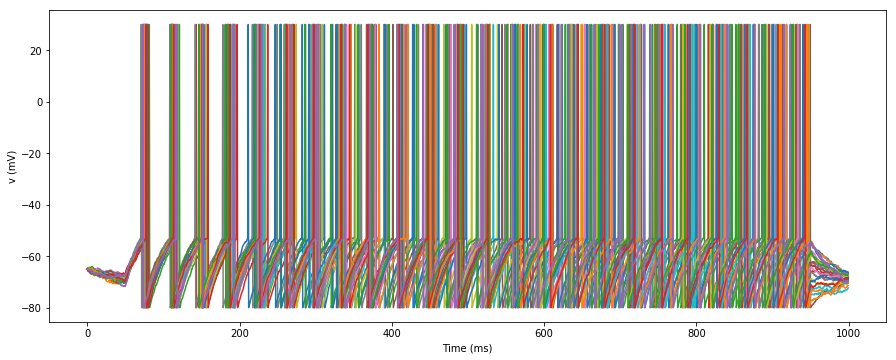

rho= 1.0


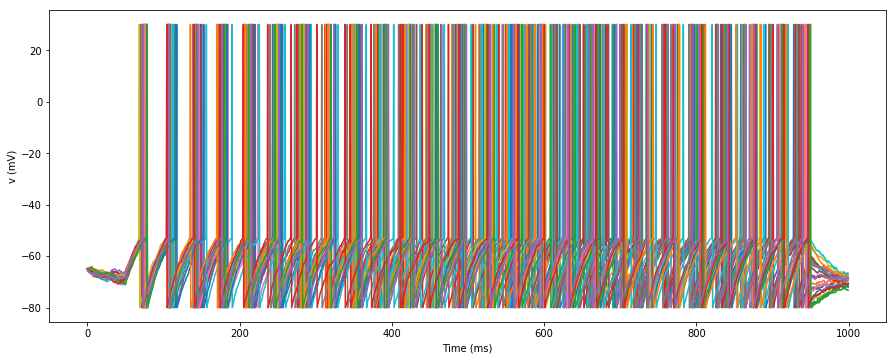

rho= 1.05


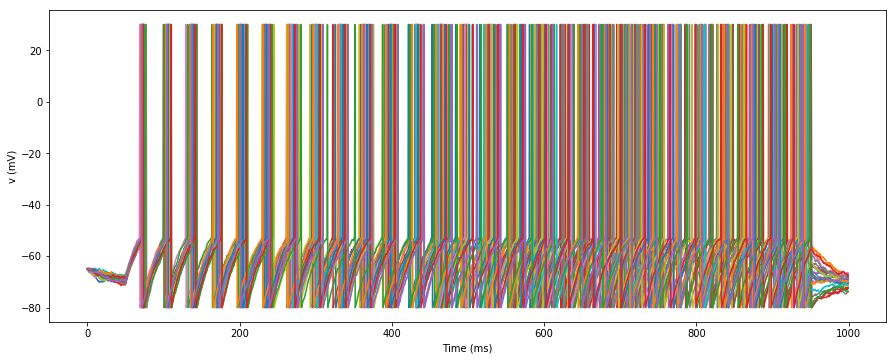

rho= 1.1


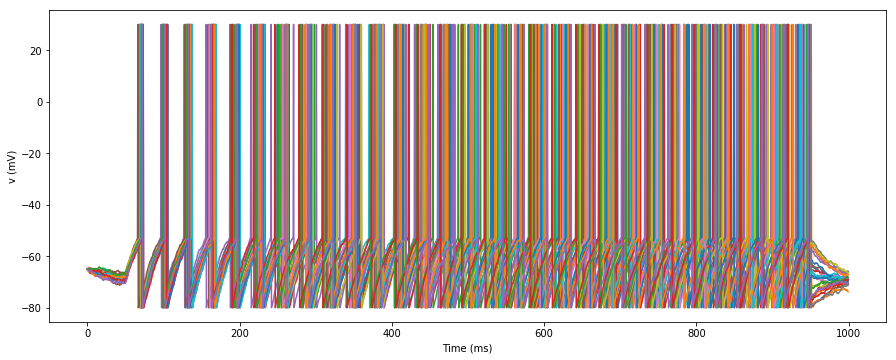

In [23]:
for rho in np.linspace(0.9, 1.1, 5):
    print('rho=', rho)
    VA = np.zeros((n_trials,len(time)))

    for i in range(n_trials):
        VA[i, :] = leaky_IF(time, Bruit(I_n=0, I_0=rho*250))

    fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
    ax.plot(time, VA.T)
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('v (mV)');
    plt.show()

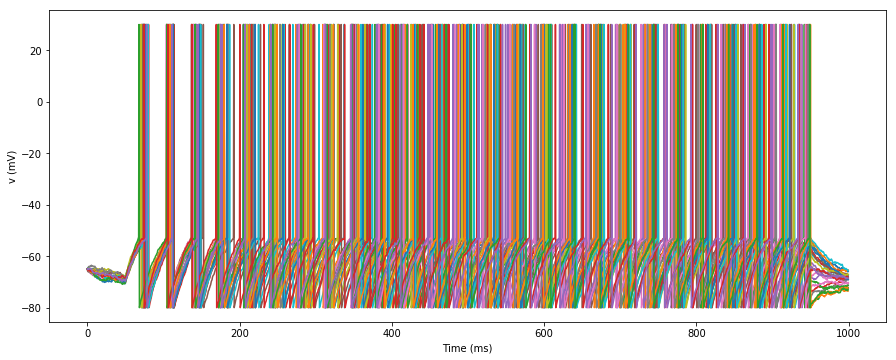

In [24]:
seed = 2019
VA = np.zeros((n_trials,len(time)))
b_A = Bruit(I_n=0, I_0=250, seed=seed)

for i in range(n_trials):
    VA[i, :] = leaky_IF(time, b_A)

fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.plot(time, VA.T)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('v (mV)');


On reproduit le paneau B: avec un bruit gelé, les traces des neurones sont reproductibles, m:^me quand le neurone possède un bruit intrinsèque:


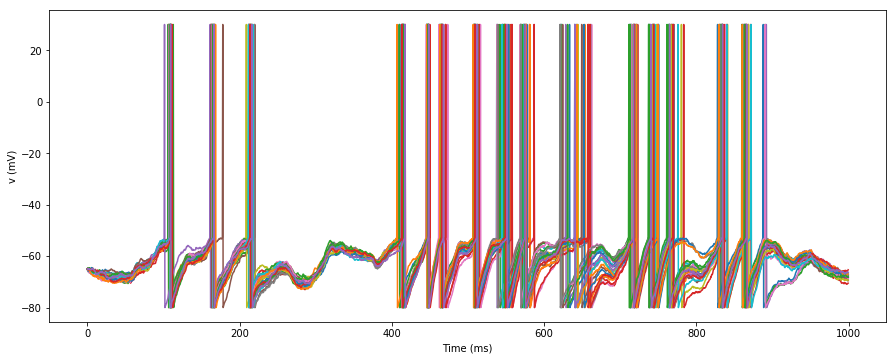

In [25]:
VB = np.zeros((n_trials, len(time)))
b_B = Bruit(I_n=1000, I_0=125, seed=seed)
for i in range(n_trials):
    VB[i, :] = leaky_IF(time, b_B)

fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.plot(time, VB.T)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('v (mV)');

Pour résumer:

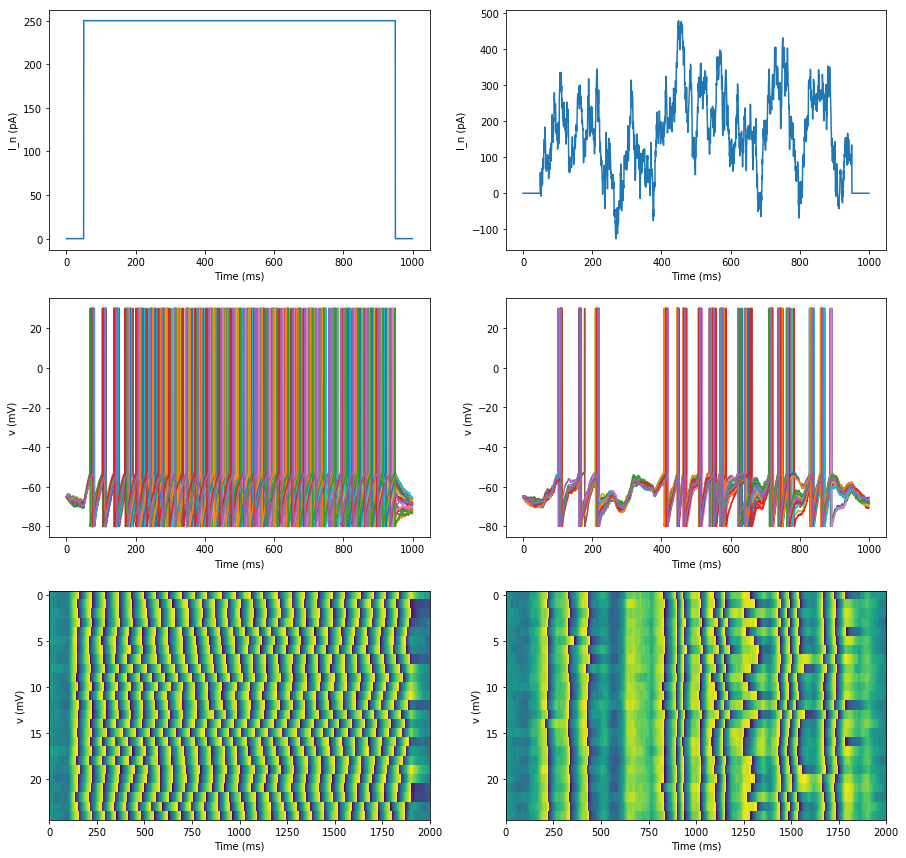

In [26]:
fig, axs = plt.subplots(3, 2, figsize=(fig_width, fig_width))

axs[0][0].plot(time, b_A)
axs[0][1].plot(time, b_B)
axs[1][0].plot(time, VA.T)
axs[1][1].plot(time, VB.T)
axs[2][0].imshow(VA, aspect=len(time)/n_trials/1.66, vmax=Vthreshold)
axs[2][1].imshow(VB, aspect=len(time)/n_trials/1.66, vmax=Vthreshold)
for ax in axs.ravel(): 
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('v (mV)');
axs[0][0].set_ylabel('I_n (pA)')
axs[0][1].set_ylabel('I_n (pA)');


Voilà !